In [24]:
## Install albumentations when first using this program
# pip install -U albumentations --no-binary qudida,albumentations

%matplotlib inline
import random

import cv2
from matplotlib import pyplot as plt
import numpy as np

import albumentations as A

    
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

In [2]:
def place_object(background, object, x_koord, y_koord, width, height):
    
    
    obj_resized = cv2.resize(object, (width, height))
    alpha_s = obj_resized[:, :, 3] / 255
    alpha_l = 1.0-alpha_s
    
    for c in range(0,3):
        background[y_koord:y_koord+height, x_koord:x_koord+width, c] = (alpha_s * obj_resized[:, :, c] + alpha_l * background[y_koord:y_koord+height, x_koord:x_koord+width, c])

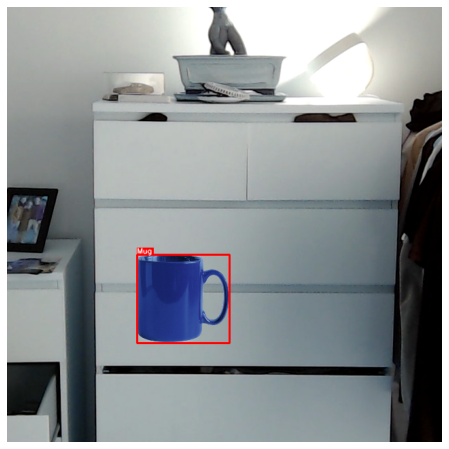

In [25]:
## 1. Place object on background (Check if this code is too slow since each object is imported twice)

# Get labels
category_id_to_name = {1: 'Mug'}

# Define current id
category_ids = [1]

# Import object and background
path_object = '/Users/niklas/Desktop/Mug_3.jpg'
path_background = '/Users/niklas/Desktop/Background1.png'

# Open object as CMYK and get alpha-channel
obj_cmyk = cv2.imread(path_object, cv2.IMREAD_UNCHANGED)
alpha = obj_cmyk[:,:,3]

# Open object second time as BGR and convert to RGB
obj_bgr = cv2.imread(path_object, cv2.IMREAD_COLOR)
b, g, r = cv2.split(obj_bgr)

# Add alpha-channel to RGB 
obj_rgb = cv2.merge([r, g, b, alpha])

# Load background and place object on background
background= cv2.imread(path_background, -1)

# Generate random size of object
rand_size = np.random.randint(100, 150)
obj_width, obj_height, _ = obj_rgb.shape
obj_ratio = obj_width / obj_height
bnd_width, bnd_height, _ = background.shape
y_rand = np.random.randint(bnd_height-(rand_size+1))
x_rand = np.random.randint(bnd_width-(rand_size / obj_ratio+1))

# Place object at random location on background
place_object(background, obj_rgb, x_rand, y_rand, int(rand_size/obj_ratio), height=rand_size)
bboxes = [[x_rand, y_rand, int(rand_size/obj_ratio), rand_size]]

# Draw bbox
visualize(background, bboxes, category_ids, category_id_to_name)

In [53]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=0.33),
    A.RGBShift(always_apply=False, p=0.66, r_shift_limit=30, g_shift_limit=30, b_shift_limit=30),
    A.Rotate(limit=45, p=0.66, border_mode=cv2.BORDER_CONSTANT),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

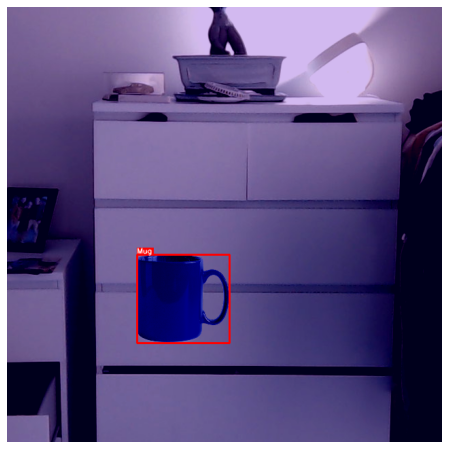

In [56]:
random.seed()
transformed = transform(image=background, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)